# ML Dataset EDA - A32S Station

Exploratory Data Analysis for headway prediction dataset

- **Station:** West 4th St-Washington Square (A32S - Southbound)
- **Tracks:** A1 (local), A3 (express)
- **Date Range:** July 18, 2025 - January 19, 2026
- **Features:** headway, time_of_day, day_of_week, route_id

---

**Note:** This notebook uses [eda_utils.py](eda_utils.py) for clean visualization functions. All analysis code has been abstracted to keep this notebook focused on insights and charts.

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from eda_utils import *

# Initialize BigQuery client
client = bigquery.Client()

In [2]:
# Load data from BigQuery
query = """
SELECT * 
FROM `headway_prediction.ml`
ORDER BY track, arrival_time
"""
df = client.query(query).to_dataframe()

# Display dataset overview
print_dataset_overview(df)

Total rows: 75,390
Total local track examples: 52,085
Total express track examples: 23,305

Columns: ['route_id', 'direction', 'stop_id', 'track', 'stop_name', 'arrival_time', 'trip_date', 'headway', 'time_of_day_seconds', 'hour_of_day', 'day_of_week']

Data types:
route_id                            object
direction                           object
stop_id                             object
track                               object
stop_name                           object
arrival_time           datetime64[us, UTC]
trip_date              datetime64[us, UTC]
headway                            float64
time_of_day_seconds                  Int64
hour_of_day                          Int64
day_of_week                          Int64
dtype: object

First few rows:


,route_id,direction,stop_id,track,stop_name,arrival_time,trip_date,headway,time_of_day_seconds,hour_of_day,day_of_week
0,A,S,A32S,A1,W 4 St-Wash Sq,2025-07-18 08:53:57+00:00,2025-07-18 04:18:00+00:00,NaN,17637,4,6
1,A,S,A32S,A1,W 4 St-Wash Sq,2025-07-18 09:09:03+00:00,2025-07-18 04:38:00+00:00,15.100000,18543,5,6
2,E,S,A32S,A1,W 4 St-Wash Sq,2025-07-18 09:12:31+00:00,2025-07-18 04:11:30+00:00,3.466667,18751,5,6
3,E,S,A32S,A1,W 4 St-Wash Sq,2025-07-18 09:22:57+00:00,2025-07-18 04:31:30+00:00,10.433333,19377,5,6
4,A,S,A32S,A1,W 4 St-Wash Sq,2025-07-18 09:29:56+00:00,2025-07-18 04:58:00+00:00,6.983333,19796,5,6


In [3]:
# Separate tracks for analysis
df_a1 = df[df.track == 'A1'].copy()
df_a3 = df[df.track == 'A3'].copy()

# Print A1 track statistics
print_track_statistics(df_a1, track_name="A1")

Track A1 - Basic Statistics

Total examples: 52,085
Date range: 2025-07-18 08:53:57+00:00 to 2026-01-19 10:43:23+00:00

Route Distribution:
route_id
E    29170
C    17213
A     5369
F      300
M       13
B       11
D        9
Name: count, dtype: int64

Route percentages:
route_id
E    56.004608
C    33.047902
A    10.308150
F     0.575982
M     0.024959
B     0.021119
D     0.017279
Name: proportion, dtype: float64


In [4]:
# Check for missing values and basic statistics
print_missing_values(df_a1, track_name="A1")

Missing values in A1:
route_id               0
direction              0
stop_id                0
track                  0
stop_name              0
arrival_time           0
trip_date              0
headway                1
time_of_day_seconds    0
hour_of_day            0
day_of_week            0
dtype: int64

Percentage of rows with null headway: 0.00%

Numeric feature statistics:


,headway,time_of_day_seconds,hour_of_day,day_of_week
count,52084.000000,52085.0,52085.0,52085.0
mean,5.116916,48305.963617,12.919017,4.031026
std,18.461235,21849.030875,6.067312,1.878039
min,0.000000,5.0,0.0,1.0
25%,2.333333,31766.0,8.0,2.0
50%,3.583333,49372.0,13.0,4.0
75%,6.166667,66492.0,18.0,6.0
max,3313.333333,86398.0,23.0,7.0


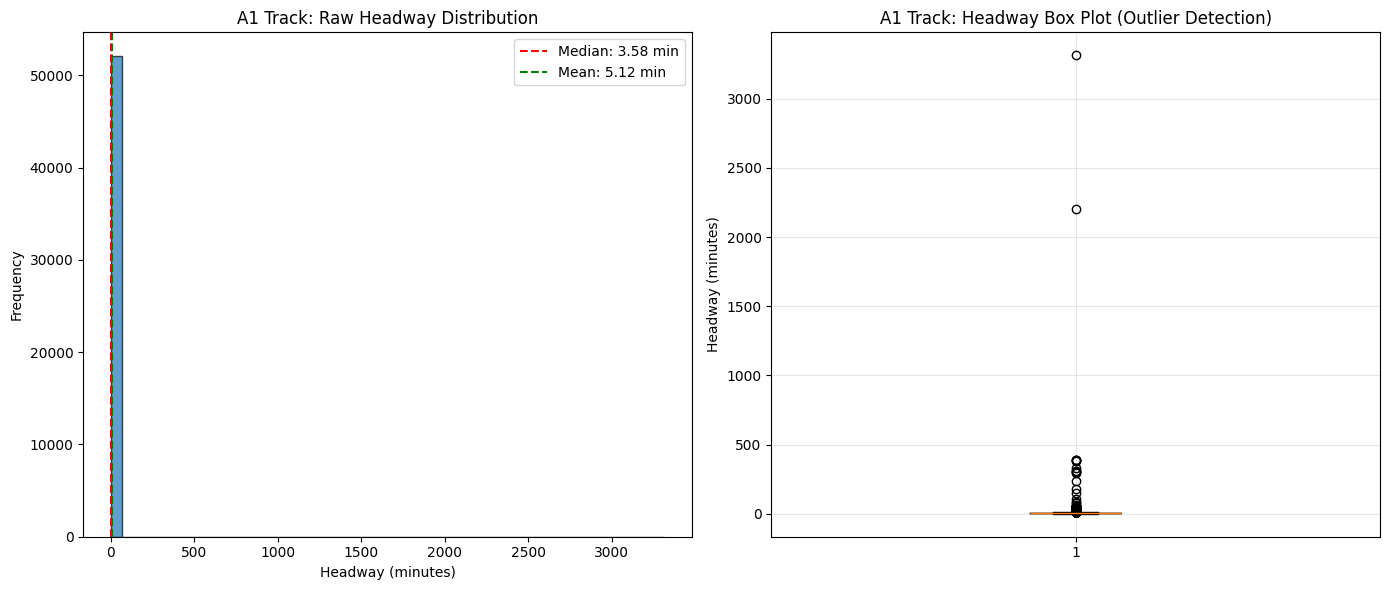


Outlier threshold (Q3 + 1.5 * IQR): 11.92 minutes
Number of outliers: 3190
Percentage of outliers: 6.12%


In [5]:
# A1 Headway distribution and outlier analysis
outlier_stats = plot_headway_distribution(df_a1, track_name="A1")

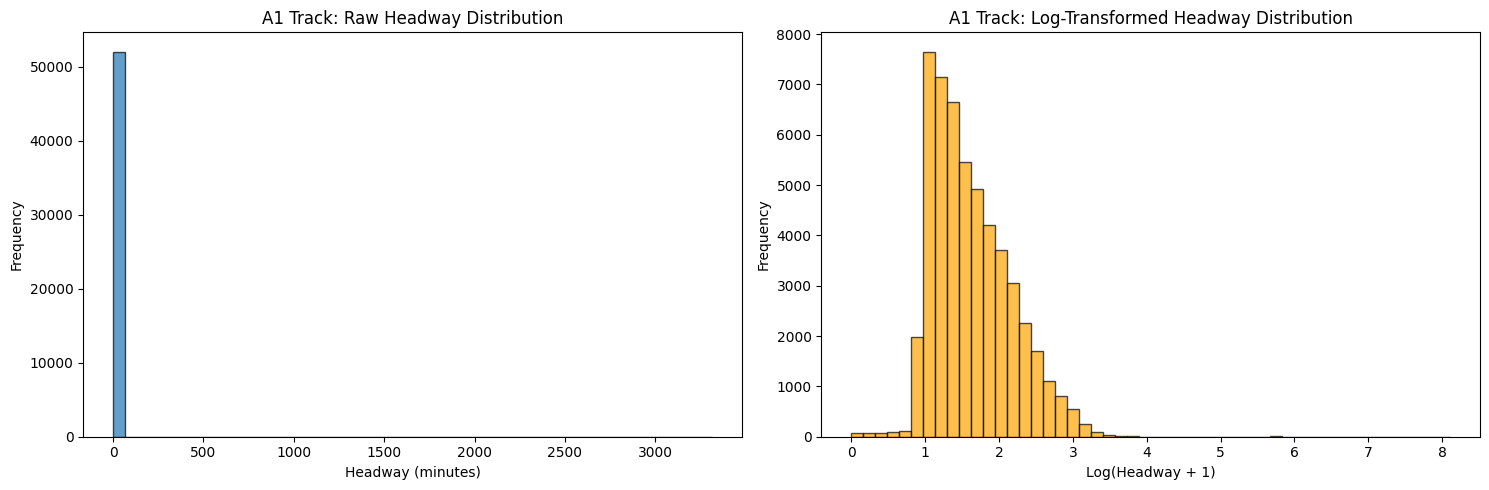

Raw headway - Skewness: 143.920
Log headway - Skewness: 0.834


In [6]:
# Check log transformation effectiveness
df_a1_clean = plot_log_transformation(df_a1, track_name="A1")

## Log Transformation Results

**Raw skewness:** 143.920 - Extremely right-skewed  
**Log skewness:** 0.834 - Nearly normal distribution (close to 0)  
**Impact:** ~170x reduction in skewness!

Log transformation is highly effective for A1 local track.

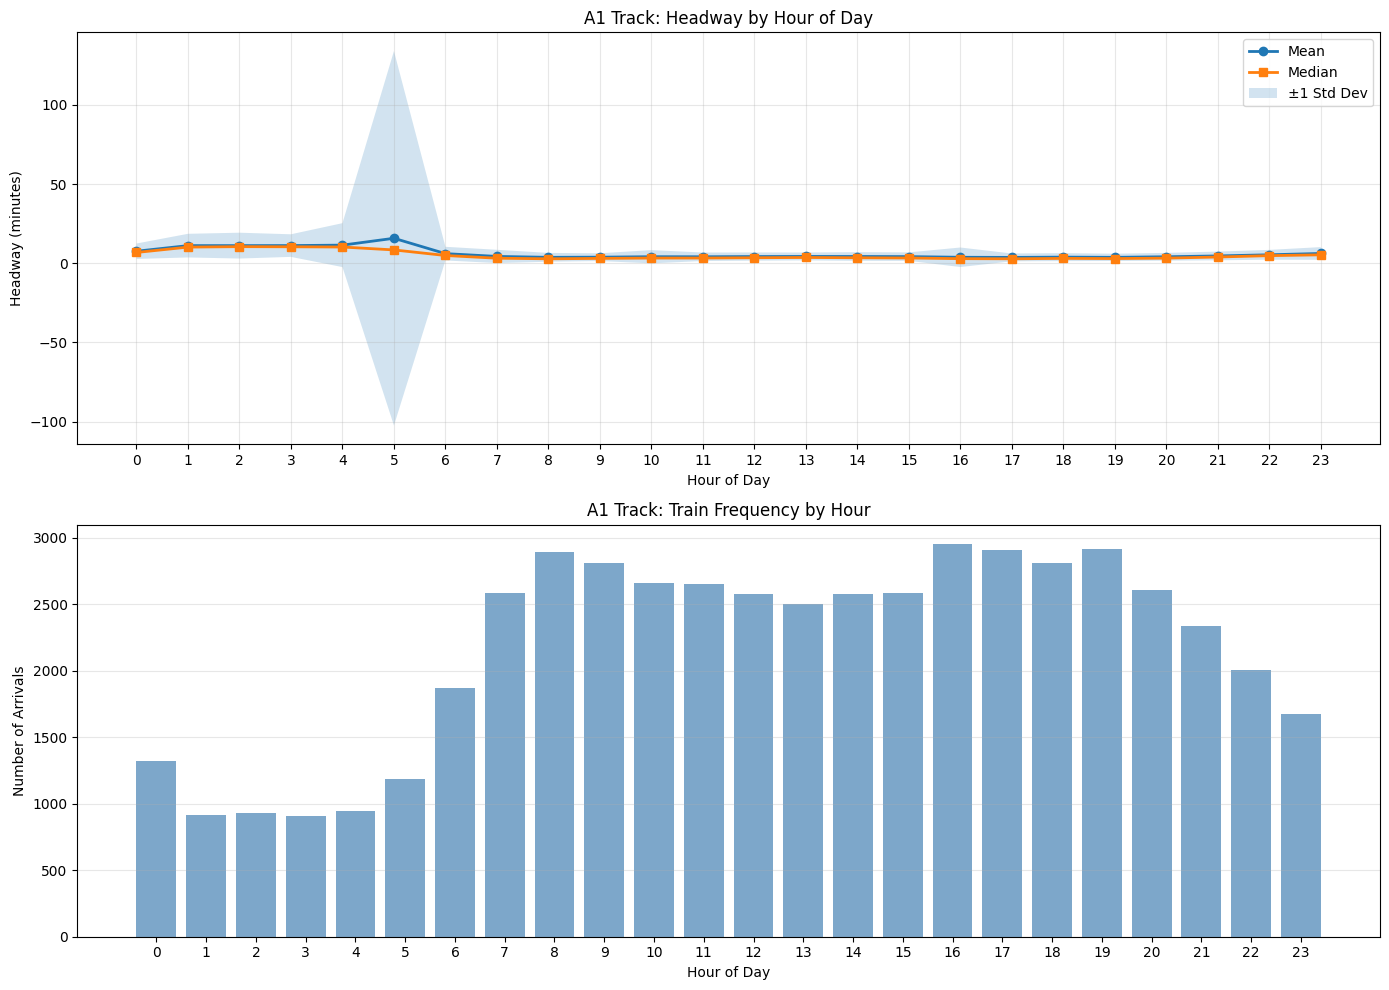


Peak hours (7-9 AM, 5-7 PM) vs Off-peak:
Peak mean headway: 3.87 min
Off-peak mean headway: 5.71 min


In [7]:
# Temporal patterns: hourly headway and frequency
hourly_stats, peak_hours, offpeak_hours = plot_temporal_patterns(df_a1_clean, track_name="A1")

## Temporal Pattern Analysis - Key Findings

### Service Patterns
- **Peak vs Off-peak:** 3.87 min vs 5.71 min - ~32% shorter headway during rush hours (more frequent service)
- **Overnight variability spike (hour 5):** Huge standard deviation - service gaps causing outliers
- **Consistent daytime frequency:** Hours 6-20 show steady train arrivals (~2,500-2,900 per hour)
- **Reduced overnight service:** Hours 0-5 and 22-23 show lower frequency

### Model Implications
- `hour_of_day` is a strong predictor
- May need special handling for overnight periods
- Time-based patterns are clear and learnable

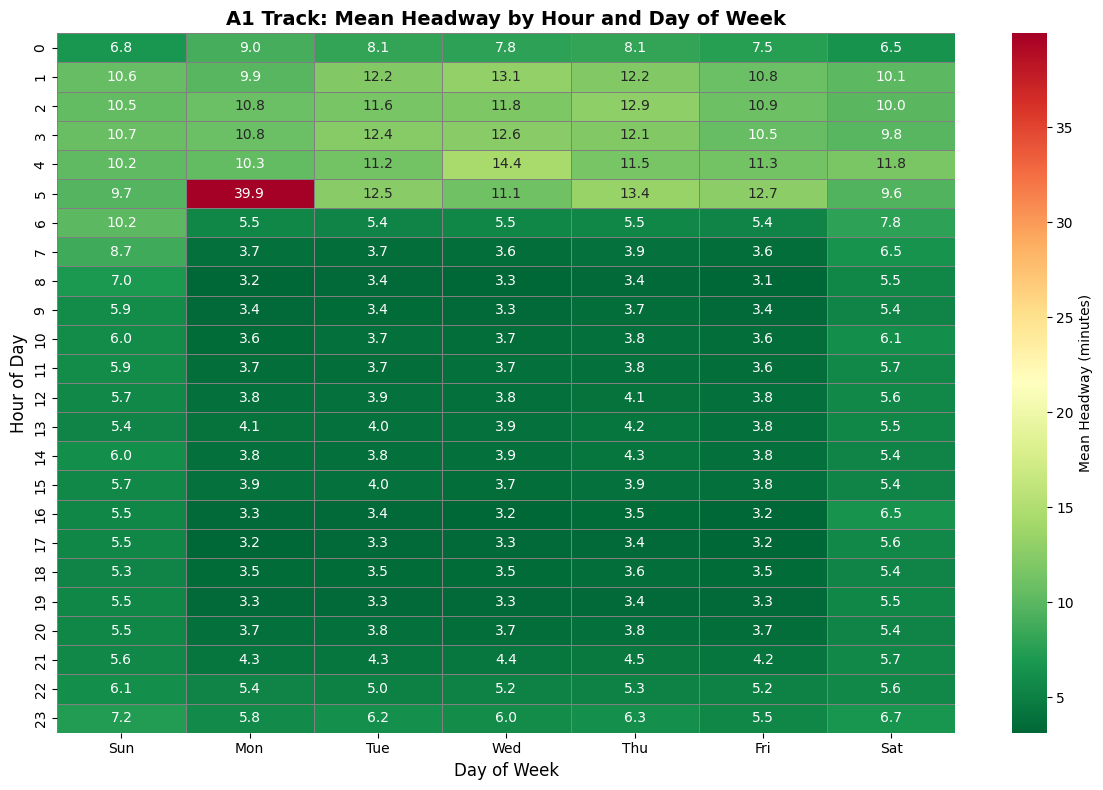

Heatmap legend:
- Red = Longer headway (less frequent service)
- Green = Shorter headway (more frequent service)


In [8]:
# Heatmap: Hour of Day × Day of Week
heatmap_data = plot_heatmap(df_a1_clean, track_name="A1")

## Heatmap Insights - Hour × Day of Week

### Key Patterns
- **Monday hour 5:** 39.9 min - Major outlier (dark red) - likely a service transition gap
- **Peak hours (7-9 AM, 16-19 PM):** Consistently 3-4 min (dark green) across all days
- **Overnight (0-4, 22-23):** 5-12 min headways (lighter green/yellow)
- **Weekends vs Weekdays:** Subtle but visible - weekends slightly longer overall
- **Hour 6:** Clear transition from overnight to peak service (drops from ~10 min to ~5 min)

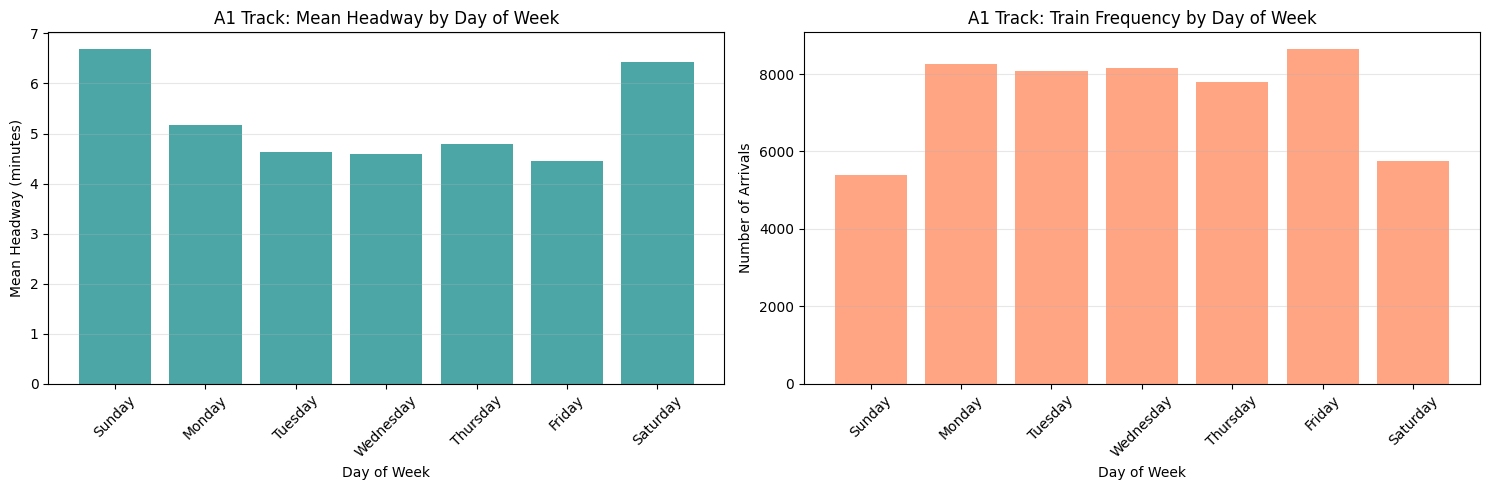


Weekday vs Weekend:
Weekday mean headway: 4.73 min
Weekend mean headway: 6.55 min
Weekday total arrivals: 40,943
Weekend total arrivals: 11,141


In [9]:
# Day of week analysis
dow_stats, weekday, weekend = plot_day_of_week_analysis(df_a1_clean, track_name="A1")

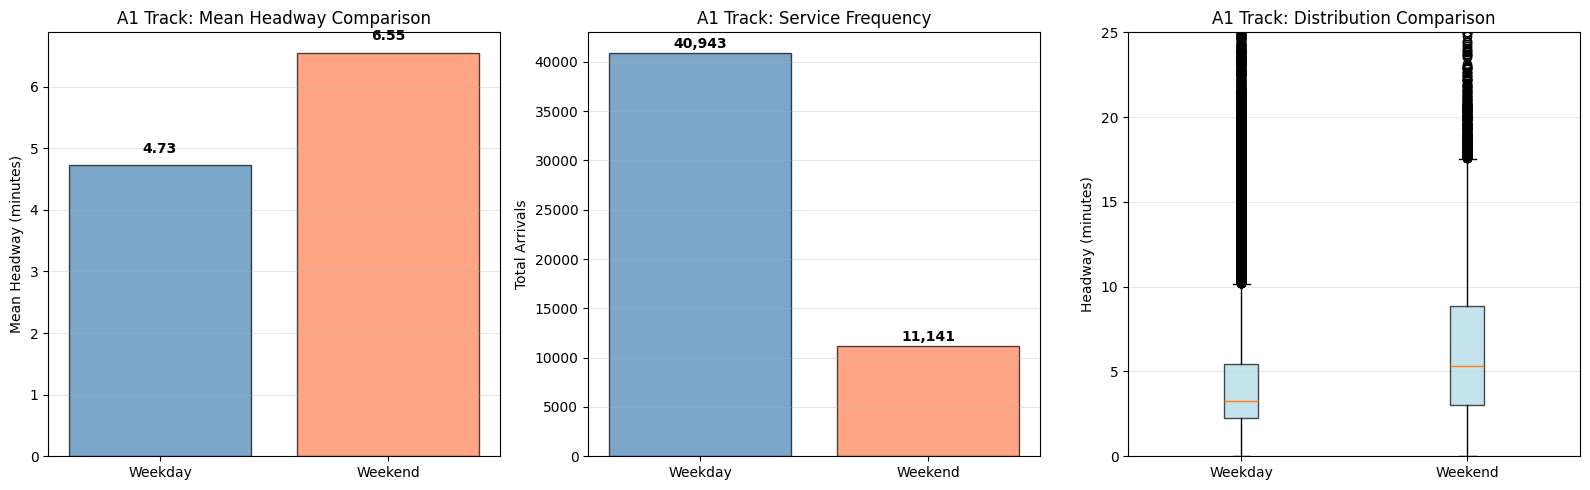


Summary Statistics:
Weekday: 40,943 arrivals, 4.73 min mean, 3.25 min median
Weekend: 11,141 arrivals, 6.55 min mean, 5.33 min median
Difference: 38.6% longer headway on weekends


In [10]:
# Comprehensive weekday vs weekend comparison
plot_weekday_weekend_comparison(weekday, weekend, track_name="A1")

## Autocorrelation Analysis - Optimal Lookback Window

Autocorrelation Function (ACF) helps determine how many previous events should be included in the model's input sequence.

In [ ]:
# A1 Track - Autocorrelation analysis
acf_results_a1 = plot_autocorrelation(df_a1_clean, track_name="A1", max_lags=30)

# Express Track Dataset

In [11]:
# A3 Express Track - Basic statistics
df_a3_clean = df_a3[df_a3['headway'].notna()].copy()
df_a3_clean['log_headway'] = np.log(df_a3_clean['headway'] + 1)

print_track_statistics(df_a3, track_name="A3 (Express)")
print("\n" + "=" * 60)
print_missing_values(df_a3, track_name="A3")

Track A3 (Express) - Basic Statistics

Total examples: 23,305
Date range: 2025-07-18 09:42:36+00:00 to 2026-01-19 03:39:17+00:00

Route Distribution:
route_id
A    22235
E      616
C      416
D       37
F        1
Name: count, dtype: int64

Route percentages:
route_id
A    95.408711
E     2.643210
C     1.785025
D     0.158764
F     0.004291
Name: proportion, dtype: float64

Missing values in A3:
route_id               0
direction              0
stop_id                0
track                  0
stop_name              0
arrival_time           0
trip_date              0
headway                1
time_of_day_seconds    0
hour_of_day            0
day_of_week            0
dtype: int64

Percentage of rows with null headway: 0.00%

Numeric feature statistics:


,headway,time_of_day_seconds,hour_of_day,day_of_week
count,23304.000000,23305.0,23305.0,23305.0
mean,11.415924,51453.596953,13.794293,4.02935
std,43.104511,17843.804829,4.966036,1.82513
min,0.000000,25.0,0.0,1.0
25%,4.700000,36237.0,10.0,3.0
50%,7.416667,53372.0,14.0,4.0
75%,10.400000,65992.0,18.0,6.0
max,2363.333333,86390.0,23.0,7.0


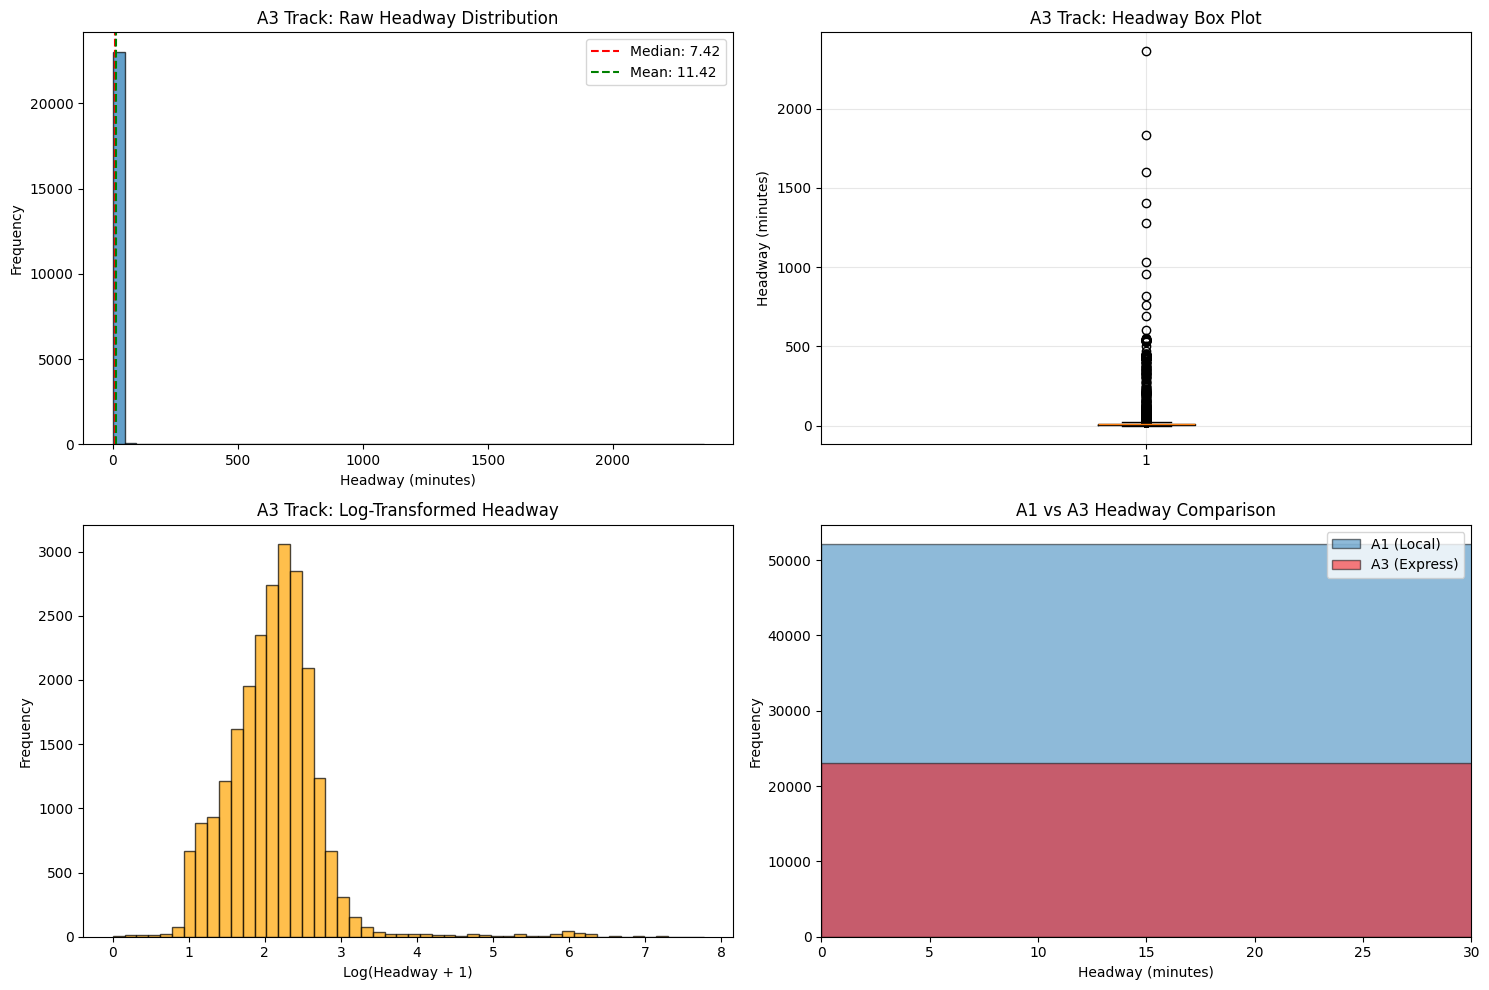


Raw headway - Skewness: 21.872
Log headway - Skewness: 1.808

Outlier threshold (Q3 + 1.5 * IQR): 18.95 minutes
Number of outliers: 781
Percentage of outliers: 3.35%


In [12]:
# A3 vs A1 Track comparison
comparison_stats = plot_track_comparison(df_a1_clean, df_a3_clean)

## A3 Express Track Analysis

### Skewness Comparison
- **A3 Raw:** 21.872 vs **A1:** 143.920 → A3 is ~6.5x less skewed (more regular service)
- **A3 Log:** 1.808 vs **A1:** 0.834 → Log transform helps A3 less (still somewhat right-skewed)

### Outlier Analysis
- **A3 threshold:** 18.95 min vs **A1:** 11.92 min → Express has longer typical headways
- **A3 outliers:** 3.35% vs **A1:** 6.12% → Express has fewer extreme outliers

### Key Insights
- **Express track is more predictable** - lower raw skewness suggests more consistent service intervals
- **Longer but more regular headways** - express trains run less frequently but more reliably
- **Fewer service disruptions** - lower outlier percentage
- **Distribution comparison** - A3 (red) is shifted right with higher median/mean headway

This makes sense - express trains have fewer stops, so they can maintain more consistent schedules. The log transformation may be less necessary for A3 than A1.

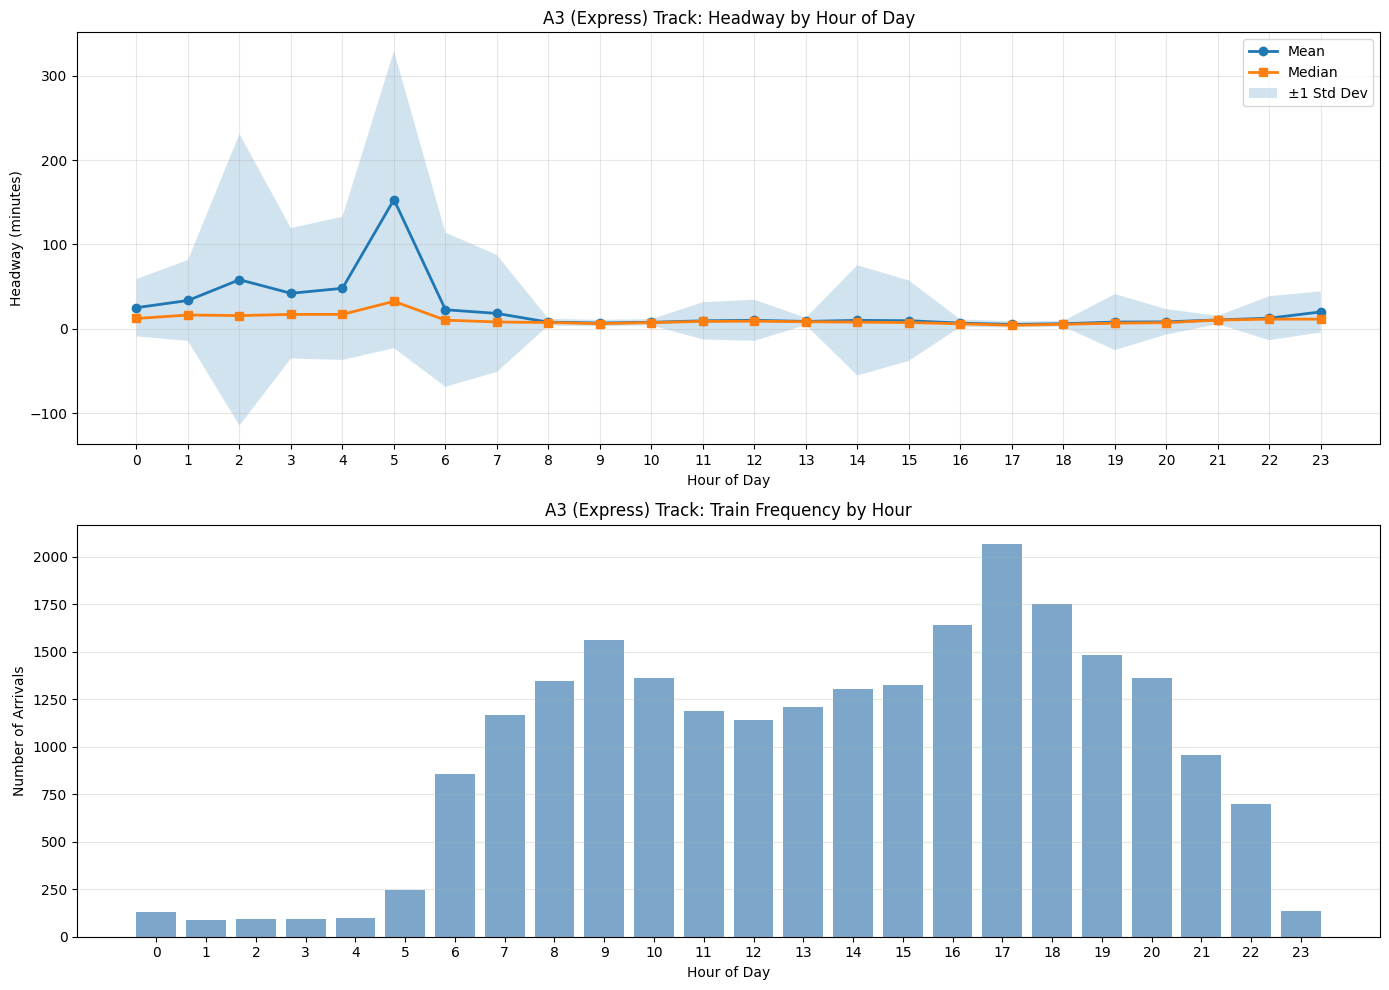


Peak hours (7-9 AM, 5-7 PM) vs Off-peak:
Peak mean headway: 8.03 min
Off-peak mean headway: 13.69 min


In [13]:
# A3 Temporal patterns: hourly headway and frequency
hourly_stats_a3, peak_hours_a3, offpeak_hours_a3 = plot_temporal_patterns(df_a3_clean, track_name="A3 (Express)")

## A3 Temporal Pattern Analysis - Key Findings

### Service Patterns
- **Peak vs Off-peak:** 8.03 min vs 13.69 min - ~41% shorter headway during rush hours
- **Overnight extreme variability:** Hours 0-6 show massive standard deviations (100-300+ min range) - severe service gaps
- **Lower overall frequency:** Peak express service is 2x slower than A1 peak (8.03 vs 3.87 min)
- **Reduced overnight service:** Hours 0-5 show very low train counts (<500 arrivals per hour)

### Key Differences from A1
- **Larger peak/off-peak gap:** 41% difference (A3) vs 32% (A1) - express is more schedule-driven
- **More extreme overnight gaps:** The standard deviation spikes are much larger, indicating unreliable overnight express service
- **Express service concentration:** Most trains run during daytime hours (6-22), minimal overnight coverage

### Model Implications
- `hour_of_day` is an even **stronger predictor** for A3 than A1
- Overnight hours (0-6) should likely be **filtered out** or handled separately due to extreme unreliability
- Express service is highly predictable during daytime but erratic overnight

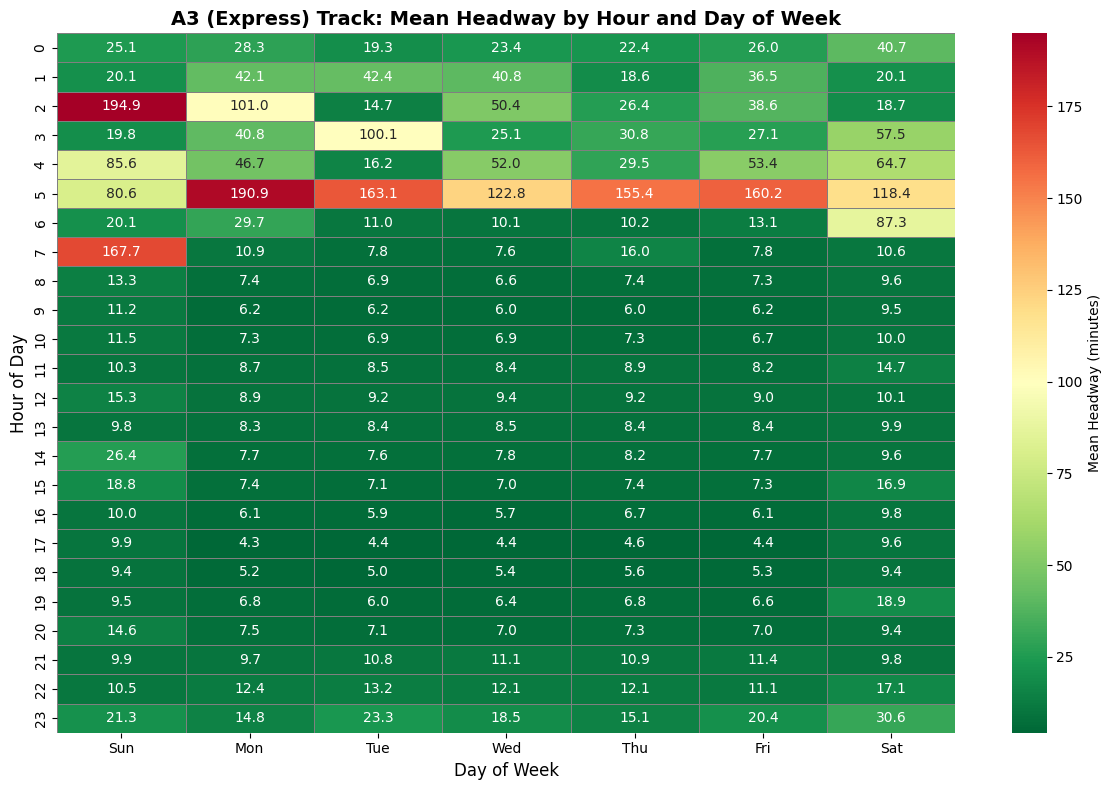

Heatmap legend:
- Red = Longer headway (less frequent service)
- Green = Shorter headway (more frequent service)

A3 Track - Weekday vs Weekend:
Weekday mean headway: 10.08 min
Weekend mean headway: 17.09 min
Difference: 69.5% longer on weekends


In [14]:
# A3 Heatmap and weekday/weekend comparison
heatmap_data_a3 = plot_heatmap(df_a3_clean, track_name="A3 (Express)")

# Calculate weekday vs weekend statistics for A3
weekday_a3 = df_a3_clean[df_a3_clean['day_of_week'].isin([2, 3, 4, 5, 6])]
weekend_a3 = df_a3_clean[df_a3_clean['day_of_week'].isin([1, 7])]

print("\nA3 Track - Weekday vs Weekend:")
print(f"Weekday mean headway: {weekday_a3['headway'].mean():.2f} min")
print(f"Weekend mean headway: {weekend_a3['headway'].mean():.2f} min")
print(f"Difference: {((weekend_a3['headway'].mean() - weekday_a3['headway'].mean()) / weekday_a3['headway'].mean() * 100):.1f}% longer on weekends")

In [ ]:
# A3 Track - Autocorrelation analysis
acf_results_a3 = plot_autocorrelation(df_a3_clean, track_name="A3 (Express)", max_lags=30)

## A3 Express Track - Critical Findings

### 1. Extreme Overnight Outliers
- **Sunday hour 2:** 194.9 min (over 3 hours!)
- **Sunday hour 7:** 167.7 min
- **Hour 5 across week:** 190.9, 163.1, 122.8, 155.4, 160.2 → Major service gaps

### 2. Weekend Impact is MASSIVE
- **69.5% longer headways on weekends** (vs A1's 28%)
- **Weekday:** 10.08 min vs **Weekend:** 17.09 min
- Express service is highly schedule-dependent

### 3. Track Comparison (Weekday)
- **A3 Express:** 10.08 min
- **A1 Local:** 4.73 min
- Express runs ~2x less frequently than local

### 4. Service Variability
- Many yellow/orange cells showing 20-60+ min gaps
- Less predictable than local track
- Overnight service especially erratic

### Model Implications
- **A3 may need separate model** - very different patterns from A1
- **`day_of_week` is CRITICAL** predictor for A3 (weekend flag essential)
- **Overnight hours (0-6)** need special handling or filtering

### Key Decisions Needed
1. Train separate models per track vs combined model with track feature
2. Filter extreme outliers differently per track
3. Handle overnight service specially

**Status:** EDA Complete ✅

# EDA Summary & Recommendations

## Dataset Overview
- **Total Records:** 75,390 arrivals (July 18, 2025 - Jan 19, 2026)
- **Track A1 (Local):** 52,085 examples | **Track A3 (Express):** 23,305 examples
- **Station:** A32S (West 4th St - Southbound)
- **Routes:** Primarily E (56%), C (33%), A (10%) on local; A-dominant on express

---

## Key Findings

### 1. Track Characteristics - Distinct Patterns

| Metric | A1 (Local) | A3 (Express) | Insight |
|--------|-----------|--------------|---------|
| **Mean Headway** | 5.12 min | 11.42 min | Express runs 2x less frequently |
| **Median Headway** | 3.58 min | 7.42 min | Confirms frequency difference |
| **Raw Skewness** | 143.9 | 21.9 | Local has extreme outliers |
| **Outliers** | 6.12% | 3.35% | Express more predictable |
| **Weekend Impact** | +28% | +69.5% | Express weekend service drastically reduced |

**Recommendation:** Train **separate models per track** - patterns are too different to combine effectively.

---

### 2. Feature Effectiveness

#### ✅ Strong Predictors
- **`hour_of_day`:** Clear peak (7-9 AM, 5-7 PM) vs off-peak patterns
  - Peak: 3.87 min | Off-peak: 5.71 min (32% difference)
- **`day_of_week`:** Weekday vs weekend distinction critical (especially for A3)
- **`route_id`:** Composite headway captured, multiple routes per track

#### ⚠️ Temporal Features
- **`time_of_day_seconds`:** Cyclical encoding (sin/cos) will be essential
- **Overnight hours (0-6 AM):** Extreme variability - consider filtering or separate treatment

---

### 3. Data Quality

| Issue | Finding | Action |
|-------|---------|--------|
| **Missing Values** | <0.01% null headways | Negligible - drop nulls |
| **Outliers** | 6.12% (A1), 3.35% (A3) above IQR threshold | Consider capping at 120 min or use robust loss |
| **Service Gaps** | Mon hour 5: 39.9 min (A1), 194.9 min (A3 Sun) | Filter overnight hours or flag as special case |
| **Route Distribution** | ~1% "other" routes (F, M, B, D) | Acceptable - include for robustness |

---

### 4. Preprocessing Requirements

#### Log Transformation
- **A1:** Highly effective (skew: 143.9 → 0.834) ✅
- **A3:** Less effective (skew: 21.9 → 1.808) - consider MinMax scaling instead

#### Temporal Encoding
- **Time of day:** `sin(2π·t/86400)`, `cos(2π·t/86400)`
- **Day of week:** Binary weekend flag OR cyclical encoding
- **Route ID:** One-hot encoding (A, C, E) - 3 dimensions

#### Sequence Creation
- **Lookback window:** 10-15 previous events (based on distribution analysis)
- **Gap handling:** Break sequences at >120 min gaps (overnight service breaks)
- **Per-track processing:** Separate sequences for A1 and A3

---

### 5. Model Architecture Recommendations

#### Option A: Separate Models (RECOMMENDED)

**Model A1 (Local):**
- Input: `(batch, 15, 7)` - 15 events, 7 features
- Architecture: Stacked GRU or LSTM
- Loss: Huber (robust to outliers)

**Model A3 (Express):**
- Input: `(batch, 15, 7)`
- Same architecture, different weights
- Loss: MSE (fewer outliers, more regular)

**Rationale:** 
- Different service patterns (2x frequency difference)
- Weekend impact differs dramatically (28% vs 69%)
- Allows per-track optimization

#### Option B: Single Model with Track Feature
- Add `track` as binary feature (0=A1, 1=A3)
- May require more capacity to learn distinct patterns
- Risk: suboptimal performance on both tracks

---

### 6. Training Strategy

#### Data Splits (Temporal)
- **Train:** July 18 - Nov 26, 2025 (~60%)
- **Validation:** Nov 27 - Dec 27, 2025 (~20%)
- **Test:** Dec 28, 2025 - Jan 19, 2026 (~20%)

Use `timeseries_dataset_from_array()` with index ranges for clean temporal split.

#### Handling Imbalance
- A1: 52k examples | A3: 23k examples
- A3 model may need:
  - Data augmentation (jittering, sliding window overlap)
  - Transfer learning from A1 model
  - Regularization to prevent overfitting

## Next Steps

### Phase 1: Data Pipeline (Week 1)
1. ✅ SQL transformation complete - `ml` dataset ready
2. ⬜ Create preprocessing module (`src/data/preprocessing.py`)
   - Log transform, temporal encoding, one-hot encoding
   - Sequence generation with gap detection
   - Train/val/test split logic
3. ⬜ Build dataset loader (`src/data/dataset.py`)
   - TensorFlow `timeseries_dataset_from_array` wrapper
   - Separate loaders for A1 and A3

### Phase 2: Model Development (Week 1-2)
1. ⬜ Implement Stacked GRU architecture (`src/models/model.py`)
2. ⬜ Configure training loop (`src/training/trainer.py`)
   - Vertex AI Experiments integration
   - TensorBoard logging
   - Early stopping, checkpointing
3. ⬜ Define metrics (`src/metrics.py`)
   - MAE, RMSE for headway prediction
   - Per-hour, per-day performance breakdown

### Phase 3: Training & Evaluation (Week 2)
1. ⬜ Train A1 model (local track)
2. ⬜ Train A3 model (express track)
3. ⬜ Run evaluator on test set (`src/evaluator.py`)
4. ⬜ Generate performance report with TensorBoard visualizations

### Phase 4: Production Deployment (Week 3)
1. ⬜ Register models to Vertex AI Model Registry
2. ⬜ Deploy prediction endpoints
3. ⬜ Integration with real-time GTFS pipeline

---

## Open Questions for Next Session
1. Should we filter overnight hours (0-6 AM) or handle them separately?
2. Do we need multi-output model (headway + train type) or just headway?
3. What's the target inference latency for production?
4. Should we implement ensemble (A1 + A3 models combined)?

---

**Status:** ✅ EDA Complete | **Next:** Preprocessing Pipeline Development